In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta 
from sklearn.preprocessing import StandardScaler

## Load Dataset

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
dataset.describe()

,Timestep,Volt,Rotate,Pressure,Vibration,State
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.373868,0.620121,0.228011,0.263795,1.685250
std,2309.54541,0.060682,0.072916,0.061553,0.072942,1.298516
min,0.00000,0.227191,0.044333,0.137542,0.117545,0.000000
25%,1999.75000,0.340376,0.610122,0.200774,0.228058,1.000000
50%,3999.50000,0.363617,0.634887,0.217498,0.250008,2.000000
75%,5999.25000,0.388500,0.657764,0.234719,0.273541,3.000000
max,7999.00000,0.836660,0.888483,0.807142,0.880185,5.000000


## Data exploration

In [4]:
volt = np.array(dataset['Volt'].tolist()).transpose()
rotate = np.array(dataset['Rotate'].tolist()).transpose()
pressure = np.array(dataset['Pressure'].tolist()).transpose()
vibration = np.array(dataset['Vibration'].tolist()).transpose()
state = np.array(dataset['State'].tolist()).transpose()

Observe distribution of feature values

Text(0.5, 1.0, 'Volt')

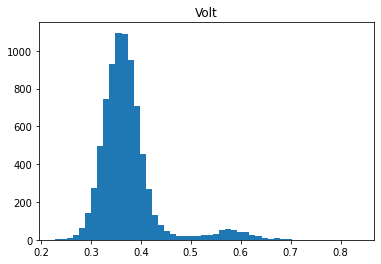

In [5]:
plt.hist(volt, bins=50)
plt.title('Volt')

Text(0.5, 1.0, 'Rotate')

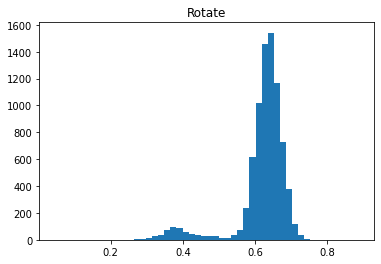

In [7]:
plt.hist(rotate, bins=50)
plt.title('Rotate')

Text(0.5, 1.0, 'Pressure')

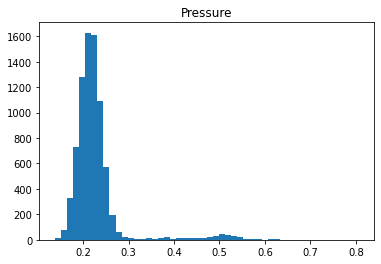

In [8]:
plt.hist(pressure, bins=50)
plt.title('Pressure')

Text(0.5, 1.0, 'Vibration')

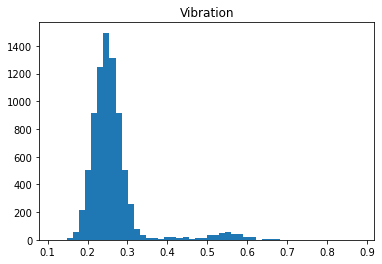

In [9]:
plt.hist(vibration, bins=50)
plt.title('Vibration')

Observe correlation of feature values

Text(0.5, 1.0, 'Correlation Heatmap')

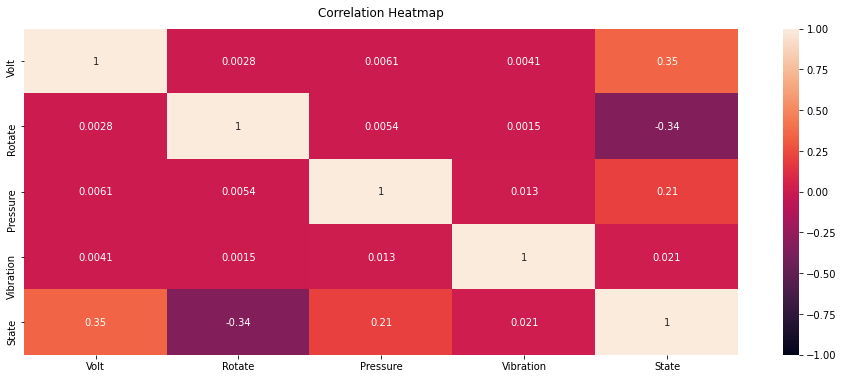

In [10]:
notimeDf = dataset.drop(columns=['Timestep'])
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(notimeDf.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

Observe variation of feature values over time

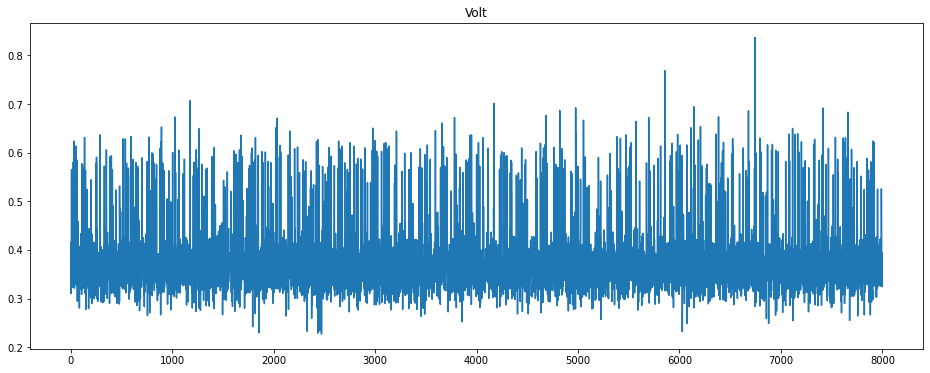

In [11]:
plt.figure(figsize=(16, 6))
plt.plot(volt)
plt.title('Volt')
plt.show()

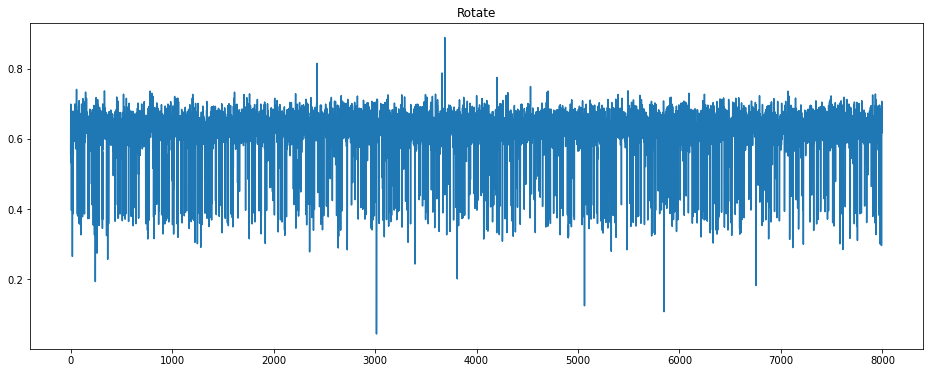

In [12]:
plt.figure(figsize=(16, 6))
plt.plot(rotate)
plt.title('Rotate')
plt.show()

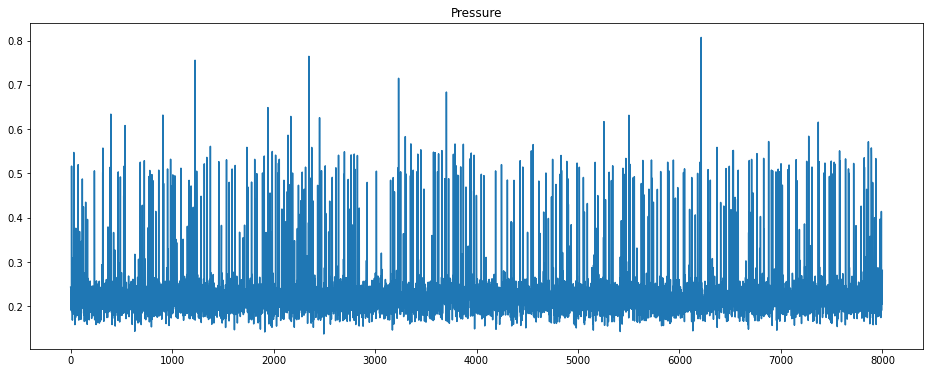

In [13]:
plt.figure(figsize=(16, 6))
plt.plot(pressure)
plt.title('Pressure')
plt.show()

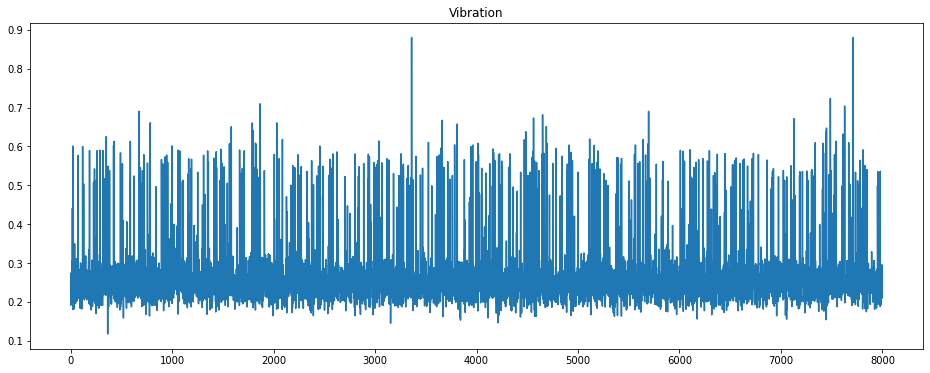

In [14]:
plt.figure(figsize=(16, 6))
plt.plot(vibration)
plt.title('Vibration')
plt.show()

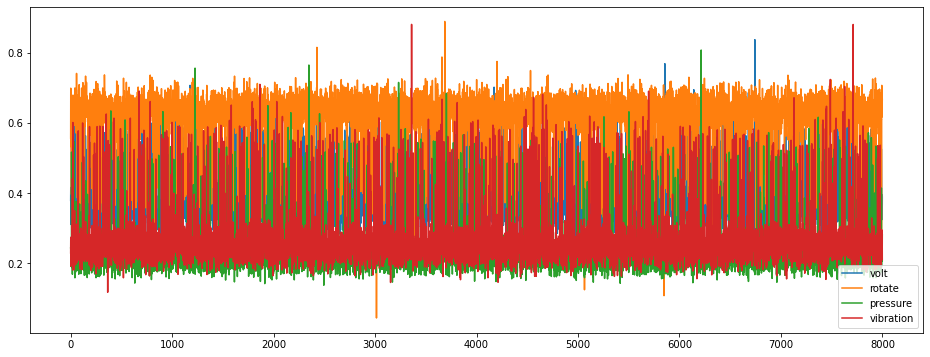

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(volt)
plt.plot(rotate)
plt.plot(pressure)
plt.plot(vibration)
plt.legend(['volt', 'rotate', 'pressure', 'vibration'], loc="lower right")
plt.show()

## Data Cleaning

Check for any null or missing values.

In [4]:
dataset.isnull()

,Timestep,Volt,Rotate,Pressure,Vibration,State
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
7995,False,False,False,False,False,False
7996,False,False,False,False,False,False
7997,False,False,False,False,False,False
7998,False,False,False,False,False,False


In [5]:
dataset.isnull().sum()

Timestep     0
Volt         0
Rotate       0
Pressure     0
Vibration    0
State        0
dtype: int64

There are no null values in the dataset. Smoothing and scaling will not be used here since the sensor readings are already scaled when generated. Smoothing is not used here as each sensor reading belongs to a particular state and taking moving averages for smoothing may not be appropriate.

## Anomaly Detection

Prepare dataset

In [6]:
#Remove timestep and states from data
featuresDf = dataset

Set aside 20% of data for validation and 20% for test.

In [7]:
numReadings = len(featuresDf)
numTrain = int(0.8*numReadings)
numVal = int(0.1*numReadings)
train_dataset = featuresDf[0:numTrain]
val_dataset = featuresDf[numTrain:numTrain+numVal]
test_dataset = featuresDf[numTrain+numVal:]

#print number of readings in each set
print("number of readings in training set %d" % len(train_dataset))
print("number of readings in validation set %d" % len(val_dataset))
print("number of readings in test set %d" % len(test_dataset))

number of readings in training set 6400
number of readings in validation set 800
number of readings in test set 800


In [8]:
train_dataset

,Timestep,Volt,Rotate,Pressure,Vibration,State
0,0,0.379151,0.556385,0.243080,0.229504,0
1,1,0.415507,0.698561,0.242410,0.273825,1
2,2,0.339342,0.637645,0.230266,0.191588,2
3,3,0.343817,0.627732,0.233905,0.264566,2
4,4,0.310362,0.607368,0.194296,0.240200,2
...,...,...,...,...,...,...
6395,6395,0.387399,0.650311,0.226403,0.275096,0
6396,6396,0.347751,0.652615,0.233748,0.289664,0
6397,6397,0.332947,0.656638,0.211010,0.255486,0
6398,6398,0.318011,0.628837,0.240318,0.286359,0


In [9]:
def splitDataByEpisode(dataFrame):
    data_split = []
    chunkBySize = []
    for index, row in dataFrame.iterrows():
        currentState = row['State']
        arr = [row['Volt'], row['Rotate'], row['Pressure'], row['Vibration']]
        if currentState > 4:
            chunkBySize.append(arr)
            if chunkBySize:
                data_split.append(chunkBySize)
            chunkBySize = []
        else:
            chunkBySize.append(arr)
    return data_split

In [10]:
def splitData(data, chunk_size):
    output_x = []
    output_y = []
    for episode in data:
        for order in range(0, len(episode)):
            diff = len(episode) - order
            if diff > chunk_size+1:
                episode_chunk = []
                for i in range(0, chunk_size-1):
                    reading = episode[order+i]
                    episode_chunk.append(reading[0:])
                output_x.append(episode_chunk)
                output_y.append(episode[order+chunk_size])
    output = [output_x, output_y]
    return output

In [11]:
#configure time series data 

interval = 6

#training set
trainDataByEpisode = splitDataByEpisode(train_dataset)
train_data = splitData(trainDataByEpisode,interval)
Xtrain = np.array(train_data[0])
ytrain = np.array(train_data[1])

#validation set
valDataByEpisode = splitDataByEpisode(val_dataset)
val_data = splitData(valDataByEpisode,interval)
Xval = np.array(val_data[0])
yval = np.array(val_data[1])

#test set
testDataByEpisode = splitDataByEpisode(test_dataset)
test_data = splitData(testDataByEpisode,interval)
Xtest = np.array(test_data[0])
ytest = np.array(test_data[1])

In [12]:
Xtrain.shape

(5806, 5, 4)

In [13]:
ytrain.shape

(5806, 4)

In [14]:
Xtrain

array([[[0.37915109, 0.55638519, 0.24307951, 0.22950429],
        [0.41550699, 0.6985611 , 0.24241029, 0.27382456],
        [0.33934205, 0.63764482, 0.23026636, 0.1915881 ],
        [0.34381736, 0.627732  , 0.23390451, 0.26456635],
        [0.31036156, 0.60736811, 0.19429564, 0.24020019]],

       [[0.41550699, 0.6985611 , 0.24241029, 0.27382456],
        [0.33934205, 0.63764482, 0.23026636, 0.1915881 ],
        [0.34381736, 0.627732  , 0.23390451, 0.26456635],
        [0.31036156, 0.60736811, 0.19429564, 0.24020019],
        [0.33632764, 0.53147914, 0.21569348, 0.21578032]],

       [[0.33934205, 0.63764482, 0.23026636, 0.1915881 ],
        [0.34381736, 0.627732  , 0.23390451, 0.26456635],
        [0.31036156, 0.60736811, 0.19429564, 0.24020019],
        [0.33632764, 0.53147914, 0.21569348, 0.21578032],
        [0.39783115, 0.57521239, 0.19058555, 0.23059909]],

       ...,

       [[0.35727416, 0.64772432, 0.30775397, 0.27110209],
        [0.41509621, 0.48212381, 0.2067563 , 0.247667

In [15]:
ytrain

array([[0.39783115, 0.57521239, 0.19058555, 0.23059909],
       [0.3859741 , 0.63093395, 0.20851633, 0.2476934 ],
       [0.37694319, 0.39604728, 0.21565966, 0.25699278],
       ...,
       [0.363326  , 0.66335598, 0.22064957, 0.28469676],
       [0.36112346, 0.66224813, 0.20464626, 0.29388773],
       [0.35267164, 0.70303508, 0.22611579, 0.24328633]])

Build model

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
def timeSeriesPredictorFunction(trainX, trainY, valX, valY):
    
    #build cnn time series predictor 
    model = models.Sequential()
    model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(5,4), padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(4, activation='relu'))
    
    model.compile(loss='mae', optimizer='sgd')
    
    savemodel = ModelCheckpoint('time_series_predictor_v1')
    stopmodel = EarlyStopping(min_delta=0.0001, patience=10)
    
    learning_model = model.fit(trainX, trainY, epochs=200, batch_size=32, validation_data=(valX, valY), callbacks=[savemodel, stopmodel])
    
    return model

In [18]:
timeSeriesPredictor = timeSeriesPredictorFunction(Xtrain, ytrain, Xval, yval)

Epoch 1/200
182/182 [==============================] - 1s 2ms/step - loss: 0.1323 - val_loss: 0.1244
INFO:tensorflow:Assets written to: time_series_predictor_v1\assets
Epoch 2/200
182/182 [==============================] - 0s 2ms/step - loss: 0.1244 - val_loss: 0.1245
INFO:tensorflow:Assets written to: time_series_predictor_v1\assets
Epoch 3/200
182/182 [==============================] - 0s 2ms/step - loss: 0.1241 - val_loss: 0.1239
INFO:tensorflow:Assets written to: time_series_predictor_v1\assets
Epoch 4/200
182/182 [==============================] - 0s 2ms/step - loss: 0.1238 - val_loss: 0.1237
INFO:tensorflow:Assets written to: time_series_predictor_v1\assets
Epoch 5/200
182/182 [==============================] - 0s 2ms/step - loss: 0.1236 - val_loss: 0.1235
INFO:tensorflow:Assets written to: time_series_predictor_v1\assets
Epoch 6/200
182/182 [==============================] - 0s 2ms/step - loss: 0.1234 - val_loss: 0.1234
INFO:tensorflow:Assets written to: time_series_predictor_v1

INFO:tensorflow:Assets written to: time_series_predictor_v1\assets
Epoch 50/200
182/182 [==============================] - 0s 2ms/step - loss: 0.1214 - val_loss: 0.1210
INFO:tensorflow:Assets written to: time_series_predictor_v1\assets
Epoch 51/200
182/182 [==============================] - 0s 3ms/step - loss: 0.1214 - val_loss: 0.1211
INFO:tensorflow:Assets written to: time_series_predictor_v1\assets
Epoch 52/200
182/182 [==============================] - 0s 2ms/step - loss: 0.1214 - val_loss: 0.1211
INFO:tensorflow:Assets written to: time_series_predictor_v1\assets
Epoch 53/200
182/182 [==============================] - 0s 2ms/step - loss: 0.1214 - val_loss: 0.1210
INFO:tensorflow:Assets written to: time_series_predictor_v1\assets
Epoch 54/200
182/182 [==============================] - 0s 2ms/step - loss: 0.1214 - val_loss: 0.1211
INFO:tensorflow:Assets written to: time_series_predictor_v1\assets
Epoch 55/200
182/182 [==============================] - 0s 2ms/step - loss: 0.1213 - val

In [19]:
def findDifference(lst1, lst2):
    difference = []
    for order in range(0, len(lst1)):
        difference_row = []
        for nextord in range(0, len(lst1[order])):
            diff = lst1[order][nextord] - lst2[order][nextord]
            diff_square = diff**2
            diff_root = diff_square**0.5
            difference_row.append(diff_root)
        difference.append(difference_row)
    return difference

In [20]:
#find difference between predicted and actual 

#training set
ytrain_predict = timeSeriesPredictor.predict(Xtrain)
train_diff = findDifference(ytrain.tolist(), ytrain_predict.tolist())
print(train_diff)

#validation set
yval_predict = timeSeriesPredictor.predict(Xval)
val_diff = findDifference(yval.tolist(), yval_predict.tolist())
print(val_diff)

[[0.030603475841424477, 0.05224624197460359, 0.02251262222583672, 0.011472864406369715], [0.02005528126367817, 0.0024278034800691017, 0.0032636787634349462, 0.00233928054576818], [0.011322581080957517, 0.22548390512166322, 0.003487000820040359, 0.007938168448557992], [0.2027095114464873, 0.01962599887133165, 0.3046607804911713, 0.007815159016440532], [0.0014449875070920437, 0.026972459700465357, 0.05013114093956561, 0.030822056054977842], [0.006367383914553104, 0.012751184079926925, 0.0091287619859593, 0.002110989851011602], [0.024327820355633523, 0.008535815509982059, 0.007417045877812389, 0.06251197307688355], [0.012660424835377049, 0.040874872982310295, 0.004275344459074626, 0.0003014369632746705], [0.011014430015882481, 0.017732357869425508, 0.035840096425345774, 0.01788212154036234], [0.011685535141696901, 0.03655256514432337, 0.03050973272897839, 0.012719806444534298], [0.03699454726481599, 0.007070756396264866, 0.033751308627826854, 0.01961716550515097], [0.018688501922402623, 0

In [21]:
def analyseAnomalyScores(data):
    voltScores = []
    rotateScores = []
    pressureScores = []
    vibrationScores = []
    averageScores = []
    
    for order in range(0, len(data)):
        row = data[order]
        voltScores.append(row[0])
        rotateScores.append(row[1])
        pressureScores.append(row[2])
        vibrationScores.append(row[3])
        total = 0
        for i in range(0, len(row)):
            total += row[i]
        average = total/len(row)
        averageScores.append(average)
        
    #plot histogram of anomaly scores 
    plt.hist(voltScores, bins=100)
    plt.title('Volt')
    plt.show()
    
    plt.hist(rotateScores, bins=100)
    plt.title('Rotate')
    plt.show()
    
    plt.hist(pressureScores, bins=100)
    plt.title('Pressure')
    plt.show()
    
    plt.hist(vibrationScores, bins=100)
    plt.title('Vibration')
    plt.show()
    
    plt.hist(averageScores, bins=100)
    plt.title('Average')
    plt.show()

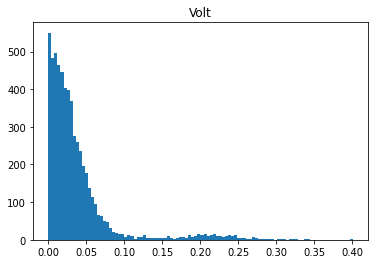

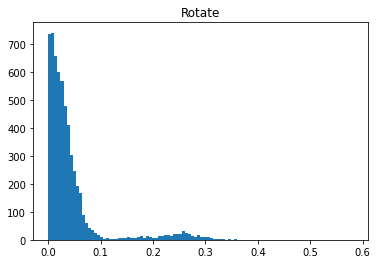

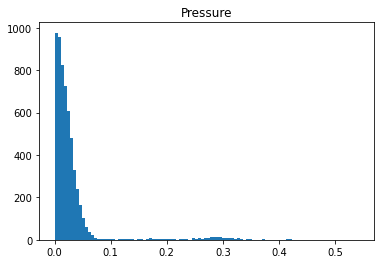

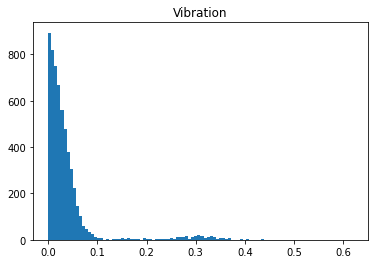

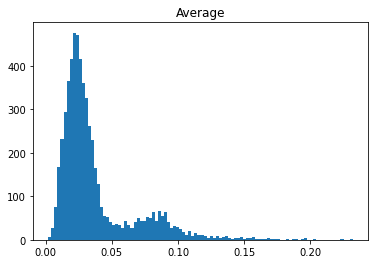

In [22]:
#analyse anomaly scores 

#training set 
analyseAnomalyScores(train_diff)

In [23]:
ytrain_predict

array([[0.36722767, 0.62745863, 0.21309817, 0.24207196],
       [0.36591882, 0.63336176, 0.21178001, 0.24535412],
       [0.3656206 , 0.6215312 , 0.21217266, 0.24905461],
       ...,
       [0.35815114, 0.6204578 , 0.21464017, 0.24993512],
       [0.35706627, 0.62299186, 0.21544954, 0.25147676],
       [0.348681  , 0.6160917 , 0.20720598, 0.24757743]], dtype=float32)

Most of the scores lies around +-0.1 for each feature and 0.05 for average for training set. 

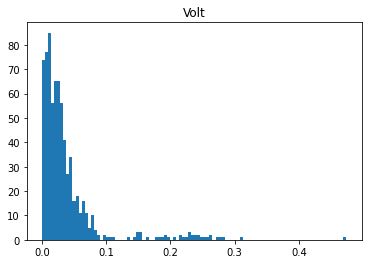

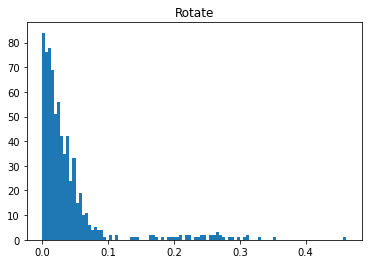

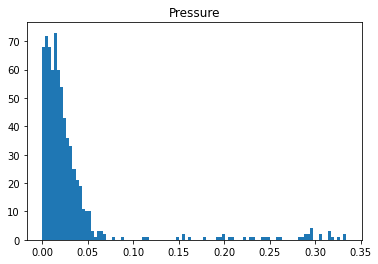

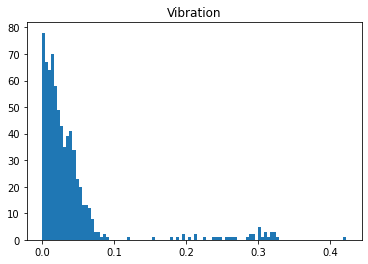

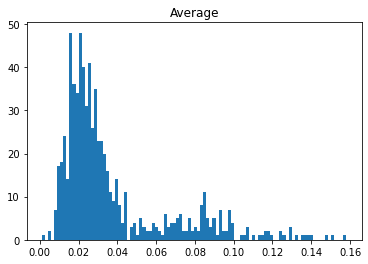

In [24]:
#analyse anomaly scores 

#training set 
analyseAnomalyScores(val_diff)

Most of the scores lies around +-0.1 for each feature (0.05 for pressure) and 0.04 for average for training set.

## Anomaly Detector 

First method of finding anomaly: If either of the features more than 0.1 diff then anomaly

In [25]:
allValuesList = dataset.values.tolist()
allValuesList

[[0.0,
  0.3791510923844879,
  0.5563851872658502,
  0.2430795056854057,
  0.229504293213304,
  0.0],
 [1.0,
  0.41550699284497095,
  0.698561103062616,
  0.2424102875207293,
  0.2738245610552764,
  1.0],
 [2.0,
  0.3393420499785441,
  0.6376448181414047,
  0.2302663582129841,
  0.19158809809304375,
  2.0],
 [3.0,
  0.34381735574648903,
  0.6277319973322149,
  0.2339045132089619,
  0.26456634913975724,
  2.0],
 [4.0,
  0.3103615567156817,
  0.6073681125184389,
  0.19429564275147734,
  0.24020019471666185,
  2.0],
 [5.0,
  0.3363276361638983,
  0.5314791420103966,
  0.215693484804905,
  0.21578032487445092,
  2.0],
 [6.0,
  0.3978311493720031,
  0.5752123900177365,
  0.1905855461472712,
  0.2305990919897332,
  2.0],
 [7.0,
  0.385974096399634,
  0.6309339533215361,
  0.2085163328904652,
  0.24769339650875036,
  2.0],
 [8.0,
  0.37694319417910205,
  0.3960472833663434,
  0.2156596580713984,
  0.2569927791777755,
  3.0],
 [9.0,
  0.5649823104615325,
  0.6481979264187865,
  0.5165871513503

In [26]:
anomalousStateListTrain = []
anomalousStatePreListTrain = []
anomalousStatePostListTrain = []
anomalousCountTrain = 0

In [27]:
anomalousStateListVal = []
anomalousStatePreListVal = []
anomalousStatePostListVal = []
anomalousCountVal = 0

In [28]:
anomalousStateListTest = []
anomalousStatePreListTest = []
anomalousStatePostListTest = []
anomalousCountTest = 0

In [29]:
def findEuclideanDistance(value1, value2):
    diff = value1 - value2
    diff_square = diff**2
    diff_root = diff_square**0.5
    return diff_root

In [30]:
def describeAnomaly(anomalousReading, data, dataType):
    anomalousIndex = 0
    for n in range(0, len(data)):
        row = data[n]
        if row[1:5] == anomalousReading: #is anomaly
            anomalousIndex = n
            if (dataType == 'Train'):
                global anomalousCountTrain
                anomalousStateListTrain.append(data[anomalousIndex][5])
                anomalousStatePreListTrain.append(data[anomalousIndex-1][5])
                anomalousStatePostListTrain.append(data[anomalousIndex+1][5])
                anomalousCountTrain =  anomalousCountTrain + 1
                print('Position of anomaly %d' % anomalousCountTrain)
            elif (dataType == 'Val'):
                global anomalousCountVal
                anomalousStateListVal.append(data[anomalousIndex][5])
                anomalousStatePreListVal.append(data[anomalousIndex-1][5])
                anomalousStatePostListVal.append(data[anomalousIndex+1][5])
                anomalousCountVal =  anomalousCountVal + 1
                print('Position of anomaly %d' % anomalousCountVal)
            elif (dataType == 'Test'):
                global anomalousCountTest
                anomalousStateListTest.append(data[anomalousIndex][5])
                anomalousStatePreListTest.append(data[anomalousIndex-1][5])
                anomalousStatePostListTest.append(data[anomalousIndex+1][5])
                anomalousCountTest =  anomalousCountTest + 1
                print('Position of anomaly %d' % anomalousCountTest)
            description = [data[anomalousIndex-2][5], data[anomalousIndex-1][5], data[anomalousIndex][5], data[anomalousIndex+1][5], data[anomalousIndex+2][5]]
            print(description)
            break

In [31]:
def findAnomaly(predicted, actual, threshold, dataType):
    for order in range(0, len(predicted)):
        voltDiff = findEuclideanDistance(predicted[order][0], actual[order][0])
        pressureDiff = findEuclideanDistance(predicted[order][2], actual[order][2])
        vibrationDiff = findEuclideanDistance(predicted[order][3], actual[order][3])
        
        if (voltDiff > threshold or pressureDiff > threshold or vibrationDiff > threshold):
            #is anomaly
            describeAnomaly(actual[order], allValuesList, dataType)

In [32]:
#training set 
findAnomaly(ytrain_predict.tolist(), ytrain.tolist(), 0.1, 'Train')

Position of anomaly 1
[2.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 2
[2.0, 2.0, 3.0, 3.0, 3.0]
Position of anomaly 3
[3.0, 3.0, 3.0, 5.0, 0.0]
Position of anomaly 4
[1.0, 1.0, 1.0, 1.0, 2.0]
Position of anomaly 5
[3.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 6
[2.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 7
[3.0, 4.0, 0.0, 0.0, 0.0]
Position of anomaly 8
[0.0, 0.0, 0.0, 1.0, 1.0]
Position of anomaly 9
[0.0, 1.0, 1.0, 1.0, 1.0]
Position of anomaly 10
[2.0, 2.0, 3.0, 3.0, 3.0]
Position of anomaly 11
[1.0, 1.0, 2.0, 2.0, 2.0]
Position of anomaly 12
[2.0, 2.0, 3.0, 3.0, 3.0]
Position of anomaly 13
[2.0, 3.0, 3.0, 3.0, 3.0]
Position of anomaly 14
[3.0, 3.0, 3.0, 3.0, 4.0]
Position of anomaly 15
[3.0, 3.0, 3.0, 4.0, 0.0]
Position of anomaly 16
[3.0, 4.0, 0.0, 0.0, 1.0]
Position of anomaly 17
[2.0, 2.0, 2.0, 3.0, 4.0]
Position of anomaly 18
[2.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 19
[0.0, 0.0, 1.0, 1.0, 1.0]
Position of anomaly 20
[3.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 21
[3.0, 

[1.0, 2.0, 3.0, 3.0, 3.0]
Position of anomaly 249
[3.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 250
[2.0, 2.0, 3.0, 4.0, 0.0]
Position of anomaly 251
[2.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 252
[3.0, 4.0, 0.0, 0.0, 0.0]
Position of anomaly 253
[4.0, 0.0, 0.0, 0.0, 1.0]
Position of anomaly 254
[2.0, 2.0, 3.0, 3.0, 3.0]
Position of anomaly 255
[3.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 256
[2.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 257
[3.0, 3.0, 3.0, 4.0, 0.0]
Position of anomaly 258
[3.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 259
[2.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 260
[2.0, 2.0, 2.0, 2.0, 2.0]
Position of anomaly 261
[2.0, 2.0, 3.0, 3.0, 3.0]
Position of anomaly 262
[3.0, 3.0, 3.0, 4.0, 0.0]
Position of anomaly 263
[3.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 264
[2.0, 2.0, 2.0, 2.0, 3.0]
Position of anomaly 265
[3.0, 3.0, 3.0, 3.0, 3.0]
Position of anomaly 266
[3.0, 3.0, 3.0, 3.0, 4.0]
Position of anomaly 267
[3.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 268


Position of anomaly 511
[3.0, 4.0, 0.0, 0.0, 1.0]
Position of anomaly 512
[0.0, 1.0, 2.0, 2.0, 2.0]
Position of anomaly 513
[3.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 514
[2.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 515
[3.0, 3.0, 3.0, 4.0, 0.0]
Position of anomaly 516
[3.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 517
[2.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 518
[0.0, 0.0, 0.0, 1.0, 1.0]
Position of anomaly 519
[3.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 520
[2.0, 2.0, 3.0, 4.0, 0.0]
Position of anomaly 521
[2.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 522
[2.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 523
[2.0, 3.0, 3.0, 4.0, 0.0]
Position of anomaly 524
[2.0, 3.0, 3.0, 3.0, 3.0]
Position of anomaly 525
[3.0, 3.0, 3.0, 3.0, 3.0]
Position of anomaly 526
[3.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 527
[2.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 528
[0.0, 0.0, 0.0, 1.0, 2.0]
Position of anomaly 529
[3.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 530
[2.0, 2.0, 2.0, 2.0, 2.0]


Position of anomaly 728
[2.0, 3.0, 3.0, 3.0, 4.0]
Position of anomaly 729
[3.0, 4.0, 0.0, 0.0, 0.0]
Position of anomaly 730
[0.0, 0.0, 0.0, 1.0, 2.0]
Position of anomaly 731
[1.0, 2.0, 2.0, 3.0, 3.0]
Position of anomaly 732
[2.0, 2.0, 3.0, 3.0, 3.0]
Position of anomaly 733
[2.0, 3.0, 3.0, 4.0, 0.0]
Position of anomaly 734
[2.0, 3.0, 3.0, 3.0, 3.0]
Position of anomaly 735
[3.0, 3.0, 3.0, 4.0, 0.0]
Position of anomaly 736
[2.0, 2.0, 3.0, 3.0, 3.0]
Position of anomaly 737
[3.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 738
[2.0, 2.0, 3.0, 3.0, 3.0]
Position of anomaly 739
[2.0, 2.0, 3.0, 4.0, 0.0]
Position of anomaly 740
[2.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 741
[2.0, 3.0, 3.0, 3.0, 3.0]
Position of anomaly 742
[3.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 743
[3.0, 3.0, 3.0, 4.0, 0.0]
Position of anomaly 744
[3.0, 3.0, 4.0, 0.0, 1.0]
Position of anomaly 745
[0.0, 0.0, 0.0, 1.0, 1.0]
Position of anomaly 746
[3.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 747
[2.0, 3.0, 4.0, 0.0, 0.0]


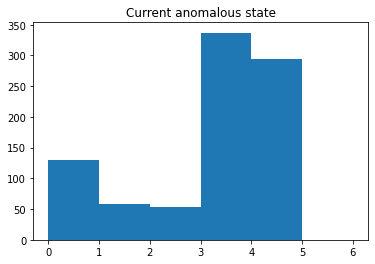

In [33]:
#plot histogram of anomaly states 
plt.hist(anomalousStateListTrain, bins=[0,1,2,3,4,5,6])
plt.title('Current anomalous state')
plt.show()

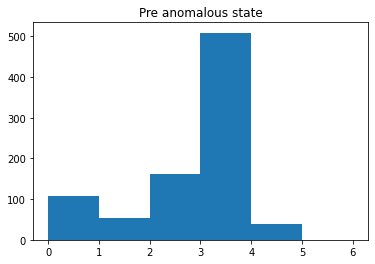

In [34]:
#plot histogram of pre anomaly states 
plt.hist(anomalousStatePreListTrain, bins=[0,1,2,3,4,5,6])
plt.title('Pre anomalous state')
plt.show()

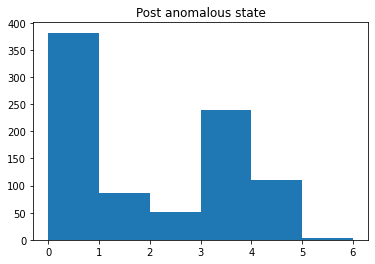

In [35]:
#plot histogram of post anomaly states 
plt.hist(anomalousStatePostListTrain, bins=[0,1,2,3,4,5,6])
plt.title('Post anomalous state')
plt.show()

In [36]:
#validation set
findAnomaly(yval_predict.tolist(), yval.tolist(), 0.1, 'Val')

Position of anomaly 1
[1.0, 2.0, 2.0, 2.0, 2.0]
Position of anomaly 2
[3.0, 3.0, 3.0, 3.0, 4.0]
Position of anomaly 3
[3.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 4
[3.0, 3.0, 3.0, 3.0, 3.0]
Position of anomaly 5
[3.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 6
[1.0, 2.0, 2.0, 2.0, 2.0]
Position of anomaly 7
[2.0, 2.0, 2.0, 2.0, 2.0]
Position of anomaly 8
[2.0, 3.0, 3.0, 4.0, 0.0]
Position of anomaly 9
[3.0, 4.0, 0.0, 0.0, 0.0]
Position of anomaly 10
[0.0, 0.0, 0.0, 0.0, 0.0]
Position of anomaly 11
[0.0, 0.0, 0.0, 0.0, 1.0]
Position of anomaly 12
[2.0, 2.0, 2.0, 2.0, 2.0]
Position of anomaly 13
[2.0, 2.0, 3.0, 3.0, 3.0]
Position of anomaly 14
[3.0, 3.0, 3.0, 3.0, 4.0]
Position of anomaly 15
[2.0, 3.0, 3.0, 3.0, 4.0]
Position of anomaly 16
[3.0, 4.0, 0.0, 1.0, 1.0]
Position of anomaly 17
[2.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 18
[1.0, 2.0, 3.0, 3.0, 3.0]
Position of anomaly 19
[2.0, 3.0, 3.0, 3.0, 3.0]
Position of anomaly 20
[3.0, 3.0, 3.0, 3.0, 4.0]
Position of anomaly 21
[3.0, 

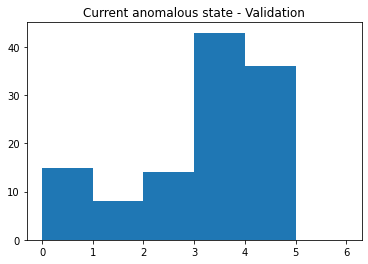

In [37]:
#plot histogram of anomaly states 
plt.hist(anomalousStateListVal, bins=[0,1,2,3,4,5,6])
plt.title('Current anomalous state - Validation')
plt.show()

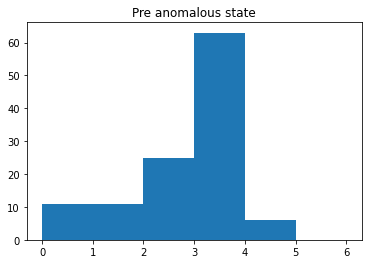

In [38]:
#plot histogram of pre anomaly states 
plt.hist(anomalousStatePreListVal, bins=[0,1,2,3,4,5,6])
plt.title('Pre anomalous state')
plt.show()

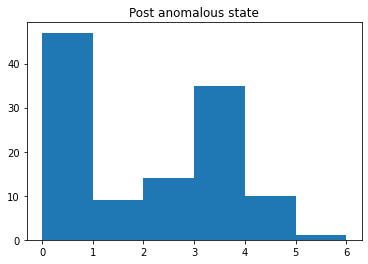

In [39]:
#plot histogram of post anomaly states 
plt.hist(anomalousStatePostListVal, bins=[0,1,2,3,4,5,6])
plt.title('Post anomalous state')
plt.show()

In [40]:
#calculate percentage of anomalies identified that are in class 4 or 5 thus failures 

#training set
train4count = anomalousStateListTrain.count(4.0)
train5count = anomalousStateListTrain.count(5.0)
train45count = train4count + train5count
traintotalcount = len(anomalousStateListTrain)
train4percent = train4count/traintotalcount
train5percent = train5count/traintotalcount
train45percent = train45count/traintotalcount
print("Percentage of anomalies identified belonging to state 4 in training set: %f" % train4percent)
print("Percentage of anomalies identified belonging to state 5 in training set: %f" % train5percent)
print("Percentage of anomalies identified belonging to state 4 and state 5 in training set: %f \n" % train45percent)

#validation set
val4count = anomalousStateListVal.count(4.0)
val5count = anomalousStateListVal.count(5.0)
val45count = val4count + val5count
valtotalcount = len(anomalousStateListVal)
val4percent = val4count/valtotalcount
val5percent = val5count/valtotalcount
val45percent = val45count/valtotalcount
print("Percentage of anomalies identified belonging to state 4 in validation set: %f" % val4percent)
print("Percentage of anomalies identified belonging to state 5 in validation set: %f" % val5percent)
print("Percentage of anomalies identified belonging to state 4 and state 5 in validation set: %f" % val45percent)

Percentage of anomalies identified belonging to state 4 in training set: 0.337915
Percentage of anomalies identified belonging to state 5 in training set: 0.000000
Percentage of anomalies identified belonging to state 4 and state 5 in training set: 0.337915 

Percentage of anomalies identified belonging to state 4 in validation set: 0.310345
Percentage of anomalies identified belonging to state 5 in validation set: 0.000000
Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.310345


In [41]:
#calculate percentage of anomalies identified for states 4 and 5 

#get all state values 
allStates = dataset['State'].tolist()
train_states = allStates[0:numTrain]
val_states = allStates[numTrain:numTrain+numVal]
test_states = allStates[numTrain+numVal:]

#training set 
orgTrain4Count = train_states.count(4)
orgTrain5Count = train_states.count(5)
orgTrain45Count = orgTrain4Count + orgTrain5Count
orgtrain4percent = train4count/orgTrain4Count
orgtrain5percent = train5count/orgTrain5Count
orgtrain45percent = train45count/orgTrain45Count
print("Percentage of points in state 4 in training set identified as anomalies: %f" % orgtrain4percent)
print("Percentage of points in state 5 in training set identified as anomalies: %f" % orgtrain5percent)
print("Percentage of points in state 4 and 5 in training set identified as anomalies: %f \n" % orgtrain45percent)

#validation set 
orgVal4Count = val_states.count(4)
orgVal5Count = val_states.count(5)
orgVal45Count = orgVal4Count + orgVal5Count
orgVal4percent = val4count/orgVal4Count
orgVal5percent = val5count/orgVal5Count
orgVal45percent = val45count/orgVal45Count
print("Percentage of points in state 4 in validation set identified as anomalies: %f" % orgVal4percent)
print("Percentage of points in state 5 in validation set identified as anomalies: %f" % orgVal5percent)
print("Percentage of points in state 4 and 5 in validation set identified as anomalies: %f \n" % orgVal45percent)

Percentage of points in state 4 in training set identified as anomalies: 0.642702
Percentage of points in state 5 in training set identified as anomalies: 0.000000
Percentage of points in state 4 and 5 in training set identified as anomalies: 0.550373 

Percentage of points in state 4 in validation set identified as anomalies: 0.580645
Percentage of points in state 5 in validation set identified as anomalies: 0.000000
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.537313 



Evaluate performance on test set

In [43]:
#test set
ytest_predict = timeSeriesPredictor.predict(Xtest)
test_diff = findDifference(ytest.tolist(), ytest_predict.tolist())
print(test_diff)

[[0.0019730314874145116, 0.002036079088070575, 0.020185958720382452, 0.0006767430456582346], [0.010443698075729535, 0.011845326924232347, 0.00033861343613816874, 0.05493187166366459], [0.008819780824150247, 0.04355049891499885, 0.0026142047245178435, 0.007454954000522429], [0.002116989114946344, 0.01445732400361055, 0.03541283395453418, 0.009207744338421892], [0.06761073788805905, 0.007450954307838598, 0.026582075620091433, 0.029127622743262305], [0.008970209443273036, 0.07906690366109526, 0.02250474764028601, 0.007837030664185729], [0.033079353073311, 0.02532705054857487, 0.045778657060606576, 0.011284018335029816], [0.058719520938186, 0.024831183046968075, 0.000946895872453335, 0.0028742533699176454], [0.03219190951214013, 0.32161010788746874, 0.0022041588680520863, 0.0063327836875228805], [0.00999465925591958, 0.014152089860423378, 0.0006706242875818558, 0.00036372517569321916], [0.029078478456232792, 0.037603241334669524, 0.037692218886083234, 0.023208802261371564], [0.047798707277

In [44]:
#test set
findAnomaly(ytest_predict.tolist(), ytest.tolist(), 0.1, 'Test')

Position of anomaly 1
[0.0, 0.0, 0.0, 1.0, 2.0]
Position of anomaly 2
[1.0, 2.0, 2.0, 2.0, 2.0]
Position of anomaly 3
[2.0, 2.0, 3.0, 4.0, 0.0]
Position of anomaly 4
[2.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 5
[2.0, 3.0, 3.0, 3.0, 4.0]
Position of anomaly 6
[3.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 7
[2.0, 2.0, 3.0, 4.0, 0.0]
Position of anomaly 8
[2.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 9
[0.0, 0.0, 0.0, 1.0, 1.0]
Position of anomaly 10
[2.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 11
[0.0, 0.0, 0.0, 0.0, 0.0]
Position of anomaly 12
[2.0, 3.0, 3.0, 4.0, 0.0]
Position of anomaly 13
[3.0, 4.0, 0.0, 0.0, 0.0]
Position of anomaly 14
[0.0, 0.0, 0.0, 1.0, 2.0]
Position of anomaly 15
[2.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 16
[2.0, 3.0, 4.0, 0.0, 0.0]
Position of anomaly 17
[3.0, 4.0, 0.0, 0.0, 0.0]
Position of anomaly 18
[0.0, 0.0, 0.0, 0.0, 1.0]
Position of anomaly 19
[0.0, 0.0, 0.0, 1.0, 1.0]
Position of anomaly 20
[1.0, 1.0, 1.0, 2.0, 2.0]
Position of anomaly 21
[2.0, 

In [45]:
#test set
test4count = anomalousStateListTest.count(4.0)
test5count = anomalousStateListTest.count(5.0)
test45count = test4count + test5count
testtotalcount = len(anomalousStateListTest)
test4percent = test4count/testtotalcount
test5percent = test5count/testtotalcount
test45percent = test45count/testtotalcount
print("Percentage of anomalies identified belonging to state 4 in test set: %f" % test4percent)
print("Percentage of anomalies identified belonging to state 5 in test set: %f" % test5percent)
print("Percentage of anomalies identified belonging to state 4 and state 5 in test set: %f" % test45percent)

Percentage of anomalies identified belonging to state 4 in test set: 0.284404
Percentage of anomalies identified belonging to state 5 in test set: 0.000000
Percentage of anomalies identified belonging to state 4 and state 5 in test set: 0.284404


In [46]:
#test set 
orgTest4Count = test_states.count(4)
orgTest5Count = test_states.count(5)
orgTest45Count = orgTest4Count + orgTest5Count
orgTest4percent = test4count/orgTest4Count
orgTest5percent = test5count/orgTest5Count
orgTest45percent = test45count/orgTest45Count
print("Percentage of points in state 4 in test set identified as anomalies: %f" % orgTest4percent)
print("Percentage of points in state 5 in test set identified as anomalies: %f" % orgTest5percent)
print("Percentage of points in state 4 and 5 in test set identified as anomalies: %f \n" % orgTest45percent)

Percentage of points in state 4 in test set identified as anomalies: 0.584906
Percentage of points in state 5 in test set identified as anomalies: 0.000000
Percentage of points in state 4 and 5 in test set identified as anomalies: 0.476923 

